In [1]:
%run util_draw.py
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from array import array
import rootpy as rpy
import rootpy.plotting.root2matplotlib as rplt
from rootpy.io import root_open
import numpy as np
import pandas as pd
import math
import ROOT
from root_numpy import root2array, root2rec, tree2rec

In [2]:
E1F_E0 = 5.497
E16_E0 = 5.754
MP = 0.93827203
ME = 0.000511
MPIX = 0.139
MPI0 = 0.135
MOMEGA = 0.78265

### eff^-1 histograms are stored in rad_hws_e1f.root, so if you want to look at existing histograms, scroll beyond the code that creates the hists from trees.

# Create radiative correction histograms

In [ ]:
dirin = '../e1f6/test/genev_rad/q2slices'
E0 = E1F_E0
EXP = 'e1f'
# dirin = '../e1f6/test/genev_rad/q2slices'
# E0 = E16_E0
# EXP = 'e16'
rad_none = 0
rad_lvl = 2
Q2Wranges = [((1.25,2.25),(1.72,3.1)),
             ((1.75,2.75),(1.72,3.1)),
             ((2.25,3.25),(1.72,2.9)),
             ((2.75,3.75),(1.72,2.8)),
             ((3.25,4.25),(1.72,2.7)),
             ((3.75,4.75),(1.72,2.6)),
             ((4.25,5.25),(1.72,2.5))]
# Q2ranges = [[(1.5, 1.7)],
#             [(2.0, 2.2)],
#             [(2.5, 2.7)],
#             [(3.0, 3.2)],
#             [(3.5, 3.7)],
#             [(4.0, 4.2)],
#             [(4.5, 4.7)]]
DQ2 = 1
Q2ranges = [[(Q2val,Q2val+DQ2) for Q2val in np.arange(Q2r[0],Q2r[1],DQ2)] for Q2r,Wr in Q2Wranges]
fn_tmpl = 'genev_rad_%d.%s.%.2f-%.2f_%.2f-%.1f.root'
hW_tmpl = 'hW_r%d_%d_%d(80,1.6,3.2)'
hW_desc_tmpl = 'Q2=[%.3f,%.3f)'
hW_effs = []
for isim, ((Q20, Q21), (W0, W1)) in enumerate(Q2Wranges):
    hQ2W_r0, hQ2W_r2 = None, None
    fn = fn_tmpl%(rad_none,EXP,Q20,Q21,W0,W1)
    fn_r0 = '%s/%s'%(dirin,fn)
    fn = fn_tmpl%(rad_lvl,EXP,Q20,Q21,W0,W1)
    fn_r2 = '%s/%s'%(dirin,fn)
    sQ2 = '(2*%.3f*mcp[0]*(1-cos(TMath::DegToRad()*mctheta[0])))'%E0
    sW = '(sqrt(%.3f*%.3f+2*%.3f*(%.3f-mcp[0])-%s))'%(MP,MP,MP,E0,sQ2)
    snu = '((%s*%s-%.3f*%.3f+%s)/(2*%.3f))'%(sW,sW,MP,MP,sQ2,MP)
    sMMp0 = '(%s+%.3f-sqrt(%.3f*%.3f+mcp[1]*mcp[1]))'%(snu,MP,MP,MP)
    sMMp3 = '(%.3f-mcp[0]*cos(TMath::DegToRad()*mctheta[0])-mcp[1]*cos(TMath::DegToRad()*mctheta[1]))'%(E0)
    sMMp2 = '(-mcp[0]*sin(TMath::DegToRad()*mctheta[0])*sin(TMath::DegToRad()*mcphi[0])-mcp[1]*sin(TMath::DegToRad()*mctheta[1])*sin(TMath::DegToRad()*mcphi[1]))'
    sMMp1 = '(-mcp[0]*sin(TMath::DegToRad()*mctheta[0])*cos(TMath::DegToRad()*mcphi[0])-mcp[1]*sin(TMath::DegToRad()*mctheta[1])*cos(TMath::DegToRad()*mcphi[1]))'
    sMMp = '(sqrt(%s*%s-%s*%s-%s*%s-%s*%s))'%(sMMp0,sMMp0,sMMp1,sMMp1,sMMp2,sMMp2,sMMp3,sMMp3)
    with root_open(fn_r0) as fin0:
        with root_open(fn_r2) as fin2:
            for irange, (Q2r0, Q2r1) in enumerate(Q2ranges[isim]):
                tr0 = fin0.h10
                tr2 = fin2.h10
                tr0.SetAlias('Q2', sQ2)
                tr2.SetAlias('Q2', sQ2)
                n0, n2 = tr0.get_entries(), tr2.get_entries()
                hd = hW_desc_tmpl%(Q2r0,Q2r1)
                hn = hW_tmpl%(0,isim,irange)
#                 hW_r0 = tr0.Draw('%s>>%s'%(sW,hn), 'Q2>=%.3f && Q2<%.3f && %s>0.755 && %s<0.825'%(Q2r0,Q2r1,sMMp,sMMp), '')
                hW_r0 = tr0.Draw('%s>>%s'%(sW,hn), 'Q2>=%.3f && Q2<%.3f'%(Q2r0,Q2r1), '')
                hW_r0.set_title(hd)
                hn = hW_tmpl%(2,isim,irange)
                scale = 1.0*n0/n2
#                 hW_r2 = tr2.Draw('%s>>%s'%(sW,hn), '%.6f*(Q2>=%.3f && Q2<%.3f && %s>0.755 && %s<0.825)'%(scale,Q2r0,Q2r1,sMMp,sMMp), '')
                hW_r2 = tr2.Draw('%s>>%s'%(sW,hn), '%.6f*(Q2>=%.3f && Q2<%.3f)'%(scale,Q2r0,Q2r1), '')
                hW_r2.set_title(hd)
                hW_r0.Sumw2()
                hW_r2.Sumw2()
                hW_r0.Divide(hW_r2)
                hW_r0.SetDirectory(0)
                hW_effs.append(asrootpy(hW_r0))

In [4]:
with root_open('rad1_hws_e1f_500.root', 'w') as fout:
    for hw in hW_effs:
        hw.Write()

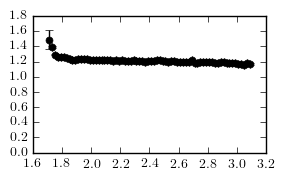

In [5]:
fig = draw(hW_effs[0])

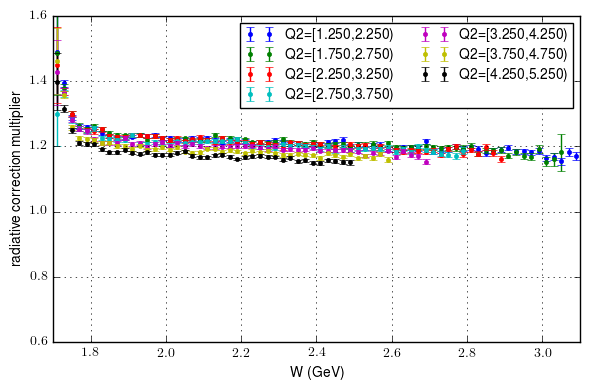

In [6]:
fig = plt.figure()
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
# for icolor, h in enumerate(hW_effs[1::38]):
# for icolor, h in enumerate(hW_effs[1::3]):
for icolor, h in enumerate(hW_effs):
    X, Y, E = list(h.x()), list(h.y()), list(zip(*h.yerr()))[0]
#     plt.errorbar(X,Y,E, fmt='.', color=colors[icolor], label=h.get_title())
    plt.errorbar(X,Y,E, fmt='.', label=h.get_title())
plt.grid()
# plt.loglog()
plt.ylim(0.6, 1.6)
plt.xlim(1.7,3.1)
# plt.ylim(0,10)
plt.legend(fontsize=10, ncol=2)
plt.xlabel(r'W (GeV)') #, fontsize=12)
plt.ylabel(r'radiative correction multiplier') #, fontsize=12)
plt.tight_layout()
plt.show()

# Get existing radiative correction histograms

In [15]:
hws = []
with root_open('rad_hws_e1f.root', 'r') as fin:
    for h in fin.objects(R.TH1):
        h.SetDirectory(0)
        hws.append(asrootpy(h))

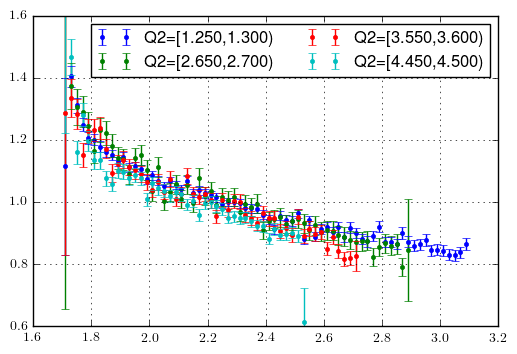

In [12]:
fig = plt.figure()
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for icolor, h in enumerate(hws[0::38]):
    X, Y, E = list(h.x()), list(h.y()), list(zip(*h.yerr()))[0]
#     plt.errorbar(X,Y,E, fmt='.', color=colors[icolor], label=h.get_title())
    plt.errorbar(X,Y,E, fmt='.', label=h.get_title())
plt.grid()
plt.ylim(0.6, 1.6)
# plt.ylim(0,10)
plt.legend(ncol=2)
plt.show()

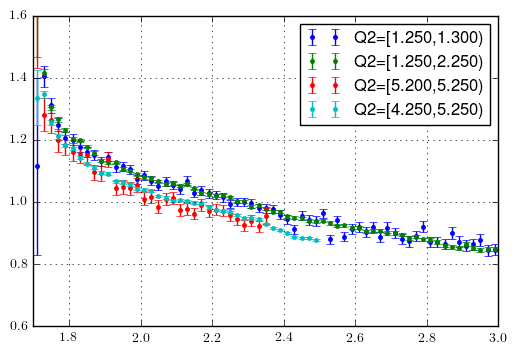

In [84]:
# hws[130]
# for h in [hws[50], hW_effs[5], hws[130], hW_effs[13]]:
for h in [hws[0], hW_effs[0], hws[-1], hW_effs[-1]]:
    X, Y, E = list(h.x()), list(h.y()), list(zip(*h.yerr()))[0]
    plt.errorbar(X,Y,E, fmt='.', label=h.get_title())
plt.grid()
plt.ylim(0.6,1.6)
plt.xlim(1.7,3)
plt.legend()

In [100]:
# frad_hix = R.TF1('frad_hix', '(x-[0])/[1]', 2.3, 3)
# frad_lox = R.TF1('frad_lox', '(-sqrt(-4*[2]*[0]+4*[2]*x+[1]*[1])-[1])/(2*[2])', 1.75, 1.88)
# frad = R.TF1('frad', '(-sqrt(-4*([2]+[3]*x)*[0]+4*([2]+[3]*x)*x+[1]*[1])-[1])/(2*([2]+[3]*x))', 1.72, 2)
# frad_lox = R.TF1('frad_lox', '-1*sqrt([0]*(x-[1]))+[2]', 1.71, 1.8)
# frad_lox.SetParLimits(0,0.01,10)
# frad_lox.SetParLimits(2, 1,2)
# frad_lox.SetParLimits(1,1.5, 1.7)
# frad = R.TF1('frad', 'pol7', 1.72, 3.1)
frad = R.TF1('frad', '[0]*TMath::Log10(x-[2])+[1]', 1.72, 3)
frad.SetParameters(-0.2, 1, 1.7)

(0.5, 1.75)

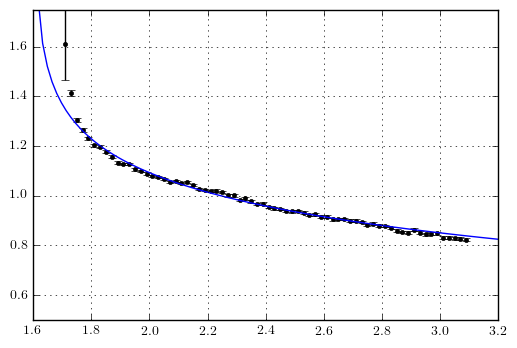

In [101]:
h = hW_effs[0]
res = h.Fit(frad, 'SR')
X, Y, E = list(h.x()), list(h.y()), list(zip(*h.yerr()))[0]
plt.errorbar(X,Y,E, fmt='.', color=colors[icolor])
Xlin = np.linspace(1.6,3.2, 100)
Y = [frad.Eval(x) for x in Xlin]
plt.plot(Xlin, Y)
plt.grid()
plt.ylim(0.5,1.75)

In [313]:
# frad_lox.FixParameter(0, 6.82631)
# frad_lox.FixParameter(1, -4.60594)
res = hW_effs[0].Fit(frad_lox, 'SRW')

In [370]:
# frad.SetParameter(0, 6.82631)
# frad.SetParameter(1, -4.60594)
# frad.SetParameter(2, 0.5)
# frad.SetParameter(3, -8)
# frad.SetParameter(4,1.7)
res = hW_effs[0].Fit(frad, 'SRF', '', 1.7, 1.8)

(0.5, 1.75)

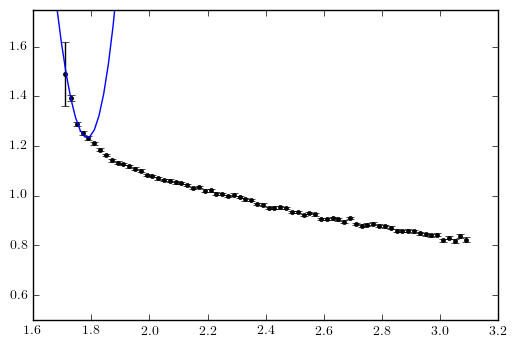

In [371]:
h = hW_effs[0]
X, Y, E = list(h.x()), list(h.y()), list(zip(*h.yerr()))[0]
plt.errorbar(X,Y,E, fmt='.', color=colors[icolor])
Xlin = np.linspace(1.6,3.2, 100)
Y = [frad.Eval(x) for x in Xlin]
# fig.axes[0].plot(Xlin, Y)
plt.plot(Xlin, Y)
Y = [frad_hix.Eval(x) for x in Xlin]
# fig.axes[0].plot(Xlin, Y)
# plt.plot(Xlin, Y)
Y = [frad_lox.Eval(x) for x in Xlin]
# fig.axes[0].plot(Xlin, Y)
# plt.plot(Xlin, Y)
plt.ylim(0.5,1.75)

In [322]:
frad.Eval(2)

1.0778799280918463

In [225]:
fn_r0, fn_r2 = '../e1f6/test/genev_e1f_rad_0.root', '../e1f6/test/genev_e1f_rad_2.root'
hQ2W_r0, hQ2W_r2 = None, None
sQ2 = '(2*%.3f*mcp[0]*(1-cos(TMath::DegToRad()*mctheta[0])))'%E1F_E0
sW = '(sqrt(%.3f*%.3f+2*%.3f*(%.3f-mcp[0])-%s))'%(MP,MP,MP,E1F_E0,sQ2)
with root_open(fn_r0) as fin:
    tr0 = asrootpy(fin.h10)
    hQ2W_r0 = tr0.Draw('%s:%s>>hQ2W_r0(80,1.6,3.2,35,0,7)'%(sW,sQ2), '', 'colz')
with root_open(fn_r2) as fin:
    tr2 = fin.h10
    hQ2W_r2 = tr2.Draw('%s:%s>>hQ2W_r2(80,1.6,3.2,35,0,7)'%(sW,sQ2), '', 'colz')

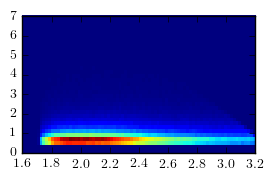

In [5]:
draw(hQ2W_r2)
plt.show()

In [6]:
hQ2W_r2.Divide(hQ2W_r0)

True

In [18]:
# bQ2_500 = hQ2W_r0.get_yaxis().FindBin(0.5)
# bQ2_1000 = hQ2W_r0.get_yaxis().FindBin(1.0)
# bQ2_1500 = hQ2W_r0.get_yaxis().FindBin(1.5)
# bQ2_2000 = hQ2W_r0.get_yaxis().FindBin(2.0)
# bQ2_2500 = hQ2W_r0.get_yaxis().FindBin(2.5)
# bQ2_3000 = hQ2W_r0.get_yaxis().FindBin(3.0)
# suffixes = ['_500_1000', '_1000_1500', '_1500_2000', '_2000_2500', '_2500_3000']
# b0b1s = [(bQ2_500, bQ2_1000), (bQ2_1000, bQ2_1500), (bQ2_1500, bQ2_2000),
#          (bQ2_2000, bQ2_2500), (bQ2_2500, bQ2_3000)]
# hWs = [hQ2W_r0.projection_x(suffix, b0, b1) for suffix, (b0,b1) in zip(suffixes, b0b1s)]
hWs = [hQ2W_r2.projection_x('_%d_%d'%(b0,b0), b0, b0) for b0 in [5]]

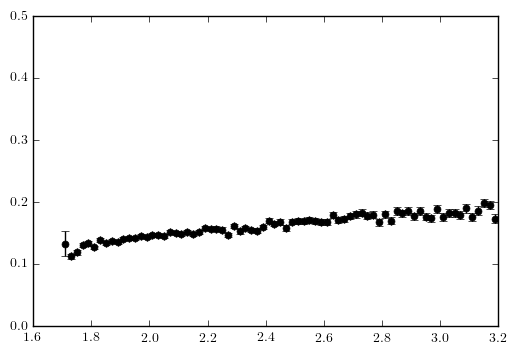

In [19]:
colors = ['k', 'b', 'r', 'g', 'y']
fig = plt.figure()
for i,hW in enumerate(hWs):
    draw(asrootpy(hW), fig=fig)
    plt.ylim(0,0.5)

In [3]:
# e0 = E1F_E0
# fn_r0, fn_r2 = '../e1f6/test/genev_e1f_rad_0.root', '../e1f6/test/genev_e1f_rad_2.root'
# df_r0, df_r2 = None, None

# with root_open(fn_r0) as fin:
#     df_r0 = pd.DataFrame(tree2rec(fin.h10, ['mcp[0]', 'mctheta[0]']))
#     df_r0.columns = ['p', 'theta']
# with root_open(fn_r2) as fin:
#     df_r2 = pd.DataFrame(tree2rec(fin.h10, ['mcp[0]', 'mctheta[0]']))
#     df_r2.columns = ['p', 'theta']

# def add_Q2W_to_df(df, e0):
#     df['Q2'] = 2*e0*df.p*(1-np.cos(np.deg2rad(df.theta)))
#     df['W'] = np.sqrt(MP**2+2*MP*(e0-df.p-df.Q2))

# add_Q2W_to_df(df_r0, e0)
# add_Q2W_to_df(df_r2, e0)



# hQ2W_r0 = np.histogram2d(df_r0.W, df_r0.Q2, bins=[np.arange(0,7,0.05), np.arange(1.5,3.2,0.02)])
# hQ2W_r2 = np.histogram2d(df_r2.W, df_r2.Q2, bins=[np.arange(0,7,0.05), np.arange(1.5,3.2,0.02)])

# im = plt.imshow(hQ2W_r0[0])
# plt.show()

# Combined E1F and E16

In [31]:
# dirin = '../e1f6/test/genev_rad/q2slices'
# E0 = E1F_E0
# EXP = 'e1f'
irange=0
hQ2W_r0 = asrootpy(R.TH2D('hQ2W_r0', 'Radiative Effects OFF', 80, 1.6, 3.2, 110, 0.75, 6.25))
hQ2W_r2 = asrootpy(R.TH2D('hQ2W_r2', 'Radiative Effects ON', 80, 1.6, 3.2, 110, 0.75, 6.25))
print(type(hQ2W_r0))
for (E0, EXP) in zip([E1F_E0,E16_E0], ['e1f','e16']):
    dirin = '../e1f6/test/genev_rad/q2slices'
#     E0 = E16_E0
#     EXP = 'e16'
    Q2Wranges = [((1.25,2.25),(1.72,3.1)),
                 ((1.75,2.75),(1.72,3.1)),
                 ((2.25,3.25),(1.72,2.9)),
                 ((2.75,3.75),(1.72,2.8)),
                 ((3.25,4.25),(1.72,2.7)),
                 ((3.75,4.75),(1.72,2.6)),
                 ((4.25,5.25),(1.72,2.5))]
    fn_tmpl = 'genev_rad_%d.%s.%.2f-%.2f_%.2f-%.1f.root'
    hW_tmpl = 'hQ2W_r%d_%d_%d(80,1.6,3.2,110,0.75,6.25)'
    hW_desc_tmpl = 'Q2=[%.3f,%.3f)'
    hW_effs = []
    for isim, ((Q20, Q21), (W0, W1)) in enumerate(Q2Wranges):
        fn = fn_tmpl%(0,EXP,Q20,Q21,W0,W1)
        fn_r0 = '%s/%s'%(dirin,fn)
        fn = fn_tmpl%(2,EXP,Q20,Q21,W0,W1)
        fn_r2 = '%s/%s'%(dirin,fn)
        sQ2 = '(2*%.3f*mcp[0]*(1-cos(TMath::DegToRad()*mctheta[0])))'%E0
        sW = '(sqrt(%.3f*%.3f+2*%.3f*(%.3f-mcp[0])-%s))'%(MP,MP,MP,E0,sQ2)
        with root_open(fn_r0) as fin0:
            with root_open(fn_r2) as fin2:
                tr0 = fin0.h10
                tr2 = fin2.h10
                tr0.SetAlias('Q2', sQ2)
                tr2.SetAlias('Q2', sQ2)
                n0, n2 = tr0.get_entries(), tr2.get_entries()
                hd = hW_desc_tmpl%(Q20,Q21)
                hn = hW_tmpl%(0,isim,irange)
                hW_r0 = tr0.Draw('%s:%s>>%s'%(sW,sQ2,hn), '', '')
                hW_r0.set_title(hd)
                hn = hW_tmpl%(2,isim,irange)
                scale = 1.0*n0/n2
                hW_r2 = tr2.Draw('%s:%s>>%s'%(sW,sQ2,hn), '%.6f'%scale, '')
                hW_r2.set_title(hd)
                hW_r0.Sumw2()
                hW_r2.Sumw2()
                print('%d: adding r0'%isim)
                hQ2W_r0.Add(hW_r0)
                print('%d: adding r0'%isim)
                hQ2W_r2.Add(hW_r2)

<class 'rootpy.plotting.hist._Hist2D_class.<locals>.Hist2D'>
0: adding r0
0: adding r0
1: adding r0
1: adding r0
2: adding r0
2: adding r0
3: adding r0
3: adding r0
4: adding r0
4: adding r0
5: adding r0
5: adding r0
6: adding r0
6: adding r0
0: adding r0
0: adding r0
1: adding r0
1: adding r0
2: adding r0
2: adding r0
3: adding r0
3: adding r0
4: adding r0
4: adding r0
5: adding r0
5: adding r0
6: adding r0
6: adding r0


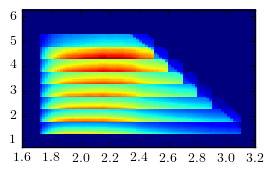

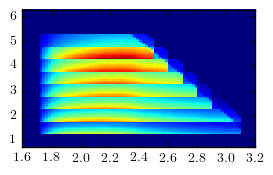

In [41]:
draw(hQ2W_r0)
draw(hQ2W_r2)
plt.show()

In [42]:
hQ2W_corr = asrootpy(hQ2W_r0.clone('hQ2W_corr'))
hQ2W_corr.Divide(hQ2W_r2)

True

In [19]:
Q2_bin0, Q2_bin1 = hQ2W_corr.yaxis.find_bin(1.25), hQ2W_corr.yaxis.find_bin(5.25)
W_bin0, W_bin1 = hQ2W_corr.xaxis.find_bin(1.75), hQ2W_corr.xaxis.find_bin(3.1)
print(W_bin0, W_bin1)
print(Q2_bin0, Q2_bin1)
Q2_bin0_val, Q2_bin1_val = hQ2W_corr.yaxis.GetBinLowEdge(Q2_bin0), hQ2W_corr.yaxis.GetBinUpEdge(Q2_bin1)
W_bin0_val, W_bin1_val = hQ2W_corr.xaxis.GetBinLowEdge(W_bin0), hQ2W_corr.xaxis.GetBinUpEdge(W_bin1)
print(W_bin0_val, W_bin1_val)
print(Q2_bin0_val, Q2_bin1_val)

8 76
11 91
1.7400000000000002 3.12
1.25 5.3


In [34]:
with root_open('hQ2W_rad_corr.root', 'w') as fout:
    hQ2W_r0.Write()
    hQ2W_r2.Write()
    hQ2W_corr.Write()

In [17]:
hQ2W_r0, hQ2W_r2, hQ2W_corr = None, None, None
with root_open('hQ2W_rad_corr.root', 'r') as fin:
    hQ2W_r0 = asrootpy(fin.hQ2W_r0)
    hQ2W_r2 = asrootpy(fin.hQ2W_r2)
    hQ2W_corr = asrootpy(fin.hQ2W_corr)
    hQ2W_r0.SetDirectory(0)
    hQ2W_r2.SetDirectory(0)
    hQ2W_corr.SetDirectory(0)

In [20]:
hcorr_Ws = []
for iQ2 in range(Q2_bin0, Q2_bin1):
    Q2val = round(1000*hQ2W_corr.yaxis.GetBinCenter(iQ2))
    hcorr_Ws.append(asrootpy(hQ2W_corr.projection_x('hcorr_Q2_%d'%Q2val, iQ2, iQ2)))

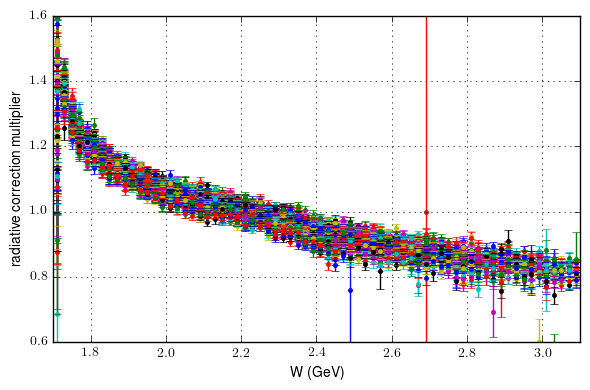

In [21]:
fig = plt.figure()
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for icolor, h in enumerate(hcorr_Ws):
    X, Y, E = list(h.x()), list(h.y()), list(zip(*h.yerr()))[0]
#     plt.errorbar(X,Y,E, fmt='.', color=colors[icolor], label=h.get_title())
    plt.errorbar(X,Y,E, fmt='.') #, label=h.get_title())
plt.grid()
plt.ylim(0.6, 1.6)
plt.xlim(1.7, 3.1)
plt.xlabel(r'W (GeV)') #, fontsize=12)
plt.ylabel(r'radiative correction multiplier') #, fontsize=12)
plt.tight_layout()
plt.show()

In [22]:
hQ2W_r0.rebin_y(4)
hQ2W_r2.rebin_y(4)
hQ2W_corr = asrootpy(hQ2W_r0.clone('hQ2W_corr'))
hQ2W_corr.Divide(hQ2W_r2)

True

In [23]:
Q2_bin0, Q2_bin1 = hQ2W_corr.yaxis.find_bin(1.25), hQ2W_corr.yaxis.find_bin(5.25)
W_bin0, W_bin1 = hQ2W_corr.xaxis.find_bin(1.75), hQ2W_corr.xaxis.find_bin(3.1)
print(W_bin0, W_bin1)
print(Q2_bin0, Q2_bin1)
Q2_bin0_val, Q2_bin1_val = hQ2W_corr.yaxis.GetBinLowEdge(Q2_bin0), hQ2W_corr.yaxis.GetBinUpEdge(Q2_bin1)
W_bin0_val, W_bin1_val = hQ2W_corr.xaxis.GetBinLowEdge(W_bin0), hQ2W_corr.xaxis.GetBinUpEdge(W_bin1)
print(W_bin0_val, W_bin1_val)
print(Q2_bin0_val, Q2_bin1_val)

8 76
3 23
1.7400000000000002 3.12
1.15 5.3500000000000005


In [24]:
hcorr_Ws = []
for iQ2 in range(Q2_bin0, Q2_bin1):
    Q2val = round(1000*hQ2W_corr.yaxis.GetBinCenter(iQ2))
    hcorr_Ws.append(asrootpy(hQ2W_corr.projection_x('hcorr_Q2_%d'%Q2val, iQ2, iQ2)))

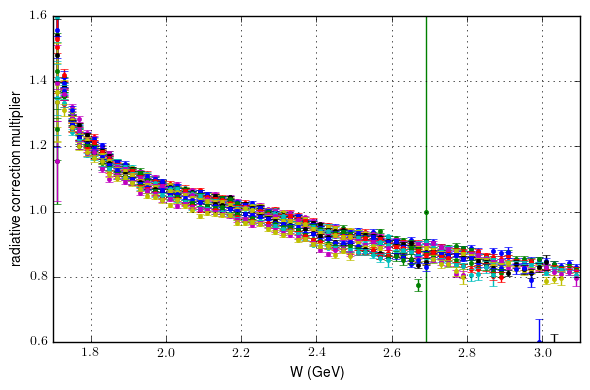

In [29]:
fig = plt.figure()
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for icolor, h in enumerate(hcorr_Ws):
    X, Y, E = list(h.x()), list(h.y()), list(zip(*h.yerr()))[0]
#     plt.errorbar(X,Y,E, fmt='.', color=colors[icolor], label=h.get_title())
    plt.errorbar(X,Y,E, fmt='.') #, label=h.get_title())
plt.grid()
plt.ylim(0.6, 1.6)
plt.xlim(1.7, 3.1)
plt.xlabel(r'W (GeV)') #, fontsize=12)
plt.ylabel(r'radiative correction multiplier') #, fontsize=12)
plt.tight_layout()
# plt.legend()
plt.show()
fig.savefig('radiative_corrections_multQ2_fnOfW.pdf')

# W and cos(theta)

In [8]:
# dirin = '../e1f6/test/genev_rad/q2slices'
# E0 = E1F_E0
# EXP = 'e1f'
irange=0
rad_none = 0
rad_lvl = 1
hCosThetaW_r0 = asrootpy(R.TH2D('hCosThetaW_r0', 'Radiative Effects OFF', 80, 1.6, 3.2, 10, -1, 1))
hCosThetaW_r2 = asrootpy(R.TH2D('hCosThetaW_r2', 'Radiative Effects ON', 80, 1.6, 3.2, 10, -1, 1))
print(type(hQ2W_r0))
for (E0, EXP) in zip([E1F_E0,E16_E0], ['e1f','e16']):
    dirin = '../e1f6/test/genev_rad/q2slices'
#     E0 = E16_E0
#     EXP = 'e16'
    Q2Wranges = [((1.25,2.25),(1.72,3.1)),
                 ((1.75,2.75),(1.72,3.1)),
                 ((2.25,3.25),(1.72,2.9)),
                 ((2.75,3.75),(1.72,2.8)),
                 ((3.25,4.25),(1.72,2.7)),
                 ((3.75,4.75),(1.72,2.6)),
                 ((4.25,5.25),(1.72,2.5))]
    fn_tmpl = 'genev_rad_%d.%s.%.2f-%.2f_%.2f-%.1f.root'
    hW_tmpl = 'hCosThetaW_r%d_%d_%d(80,1.6,3.2,10,-1,1)'
    hW_desc_tmpl = 'Q2=[%.3f,%.3f)'
    hW_effs = []
    for isim, ((Q20, Q21), (W0, W1)) in enumerate(Q2Wranges):
        fn = fn_tmpl%(rad_none,EXP,Q20,Q21,W0,W1)
        fn_r0 = '%s/%s'%(dirin,fn)
        fn = fn_tmpl%(rad_lvl,EXP,Q20,Q21,W0,W1)
        fn_r2 = '%s/%s'%(dirin,fn)
        sQ2 = '(2*%.3f*mcp[0]*(1-cos(TMath::DegToRad()*mctheta[0])))'%E0
        sCosTheta = '(cos(TMath::DegToRad()*mctheta[0]))'
        sW = '(sqrt(%.3f*%.3f+2*%.3f*(%.3f-mcp[0])-%s))'%(MP,MP,MP,E0,sQ2)
        with root_open(fn_r0) as fin0:
            with root_open(fn_r2) as fin2:
                tr0 = fin0.h10
                tr2 = fin2.h10
                tr0.SetAlias('Q2', sQ2)
                tr2.SetAlias('Q2', sQ2)
                n0, n2 = tr0.get_entries(), tr2.get_entries()
                hd = hW_desc_tmpl%(Q20,Q21)
                hn = hW_tmpl%(0,isim,irange)
                hW_r0 = tr0.Draw('%s:%s>>%s'%(sW,sCosTheta,hn), '', '')
                hW_r0.set_title(hd)
                hn = hW_tmpl%(2,isim,irange)
                scale = 1.0*n0/n2
                hW_r2 = tr2.Draw('%s:%s>>%s'%(sW,sCosTheta,hn), '%.6f'%scale, '')
                hW_r2.set_title(hd)
                hW_r0.Sumw2()
                hW_r2.Sumw2()
                print('%d: adding r0'%isim)
                hCosThetaW_r0.Add(hW_r0)
                print('%d: adding r0'%isim)
                hCosThetaW_r2.Add(hW_r2)

<class 'NoneType'>
0: adding r0
0: adding r0
1: adding r0
1: adding r0
2: adding r0
2: adding r0
3: adding r0
3: adding r0
4: adding r0
4: adding r0
5: adding r0
5: adding r0
6: adding r0
6: adding r0
0: adding r0
0: adding r0
1: adding r0
1: adding r0
2: adding r0
2: adding r0
3: adding r0
3: adding r0
4: adding r0
4: adding r0
5: adding r0
5: adding r0
6: adding r0
6: adding r0


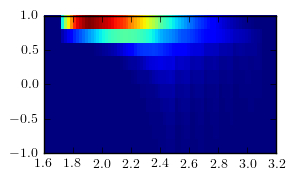

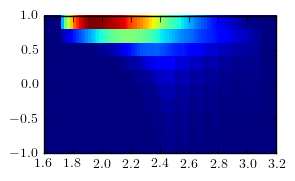

In [37]:
draw(hCosThetaW_r0)
draw(hCosThetaW_r2)
plt.show()

In [9]:
hCosThetaW_corr = asrootpy(hCosThetaW_r0.clone('hCosThetaW_corr'))
hCosThetaW_corr.Divide(hCosThetaW_r2)

True

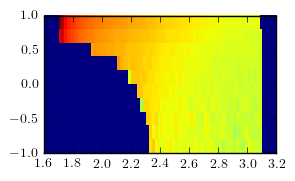

In [10]:
draw(hCosThetaW_corr)
plt.show()

In [40]:
with root_open('hCosThetaW_rad_corr.root', 'w') as fout:
    hCosThetaW_r0.Write()
    hCosThetaW_r2.Write()
    hCosThetaW_corr.Write()

In [13]:
hCosThetaW_corr2 = None
with root_open('hCosThetaW_rad_corr.root', 'r') as fin:
    hCosThetaW_corr2 = asrootpy(fin.hCosThetaW_corr)
    hCosThetaW_corr2.SetDirectory(0)

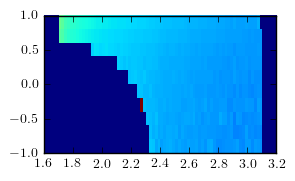

In [14]:
draw(hCosThetaW_corr2)
plt.show()

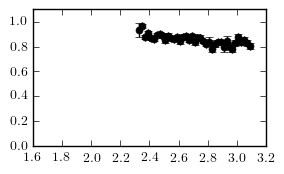

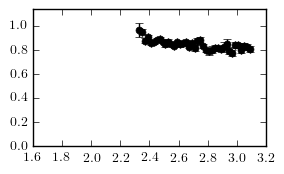

In [17]:
fig = draw(asrootpy(hCosThetaW_corr.projection_x('ctpx', 1,1)))
draw(asrootpy(hCosThetaW_corr2.projection_x('ctpx', 1,1)))
plt.show()

In [18]:
hCosThetaW_corr.xaxis.find_bin(2.6)

51

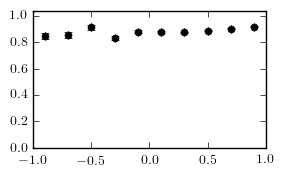

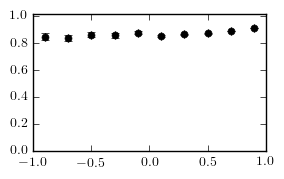

In [19]:
fig = draw(asrootpy(hCosThetaW_corr.projection_y('ctpx', 51,51)))
draw(asrootpy(hCosThetaW_corr2.projection_y('ctpx', 51,51)))
plt.show()